In [1]:
from torchvision import datasets, transforms
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [24]:
#Read MNIST dataset from folder
from torch.utils.data import random_split
origin_data = datasets.MNIST(root='./MINIST',
                               train = True,
                               transform = transforms.ToTensor())
train_dataset, test_dataset = random_split(dataset = origin_data, lengths=[50000,10000],generator=torch.Generator().manual_seed(0))
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 5,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 1,
                                           shuffle = True)

The Lable of this image is: 9


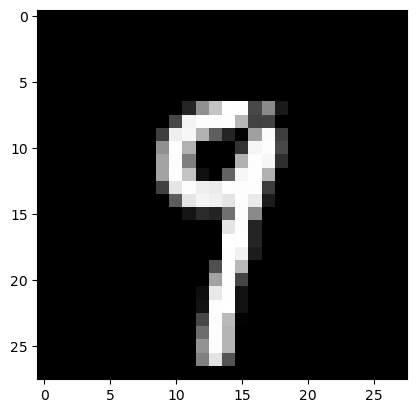

In [25]:
#This step showing the image example and the lable
import matplotlib.pyplot as plt
import torchvision
images, lables = next(iter(train_loader))
img = torchvision.utils.make_grid(images[0])#由于batch_size是5，我们取其中一张图片即可
print("The Lable of this image is:",lables[0].item())
img = img.numpy().transpose(1,2,0)#转换为【28*28*3】的矩阵再转化为图像
plt.imshow(img)
plt.show()

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#Create the CNN Module
class CNN(nn.Module):
    def __init__(self, n_input, n_output):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(n_input, 128, 3, 1, 0),
                                   nn.MaxPool2d(2), #MaxPooling with 2*2 Kernel
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 0),
                                   nn.MaxPool2d(2),
                                   nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 0),
                                   nn.ReLU())
        self.FN = nn.Linear(512*3*3,100)
        self.FN2 = nn.Linear(100,10)
    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(-1,512*3*3)
        out = self.FN(out)
        out = F.relu(out)
        out = self.FN2(out)
        out = F.softmax(out,dim=1)
        return out
    
network = CNN(1,10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

In [27]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.cuda() #Move data from CPU to GPU
    target = target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 1000 == 0:
        print("Trained:{0} batches, ths loss is {1}".format(batch_idx,loss.data.item()))
          
train(1)

Trained:0 batches, ths loss is 2.3008530139923096
Trained:1000 batches, ths loss is 2.3208260536193848
Trained:2000 batches, ths loss is 2.088243007659912
Trained:3000 batches, ths loss is 1.6535966396331787
Trained:4000 batches, ths loss is 1.8582866191864014
Trained:5000 batches, ths loss is 1.4627351760864258
Trained:6000 batches, ths loss is 1.6609588861465454
Trained:7000 batches, ths loss is 1.4612267017364502
Trained:8000 batches, ths loss is 1.6165626049041748
Trained:9000 batches, ths loss is 1.4617962837219238


In [28]:
images, lables = next(iter(test_loader))
img = images[0]#由于batch_size是5，我们取其中一张图片即可
print("The Actual Lable of this image is:",lables[0].item())
pre = network(img.cuda())
#pre.data.max(1)[1]中max(1)表示返回pre结果每一行的最大值并返回最大值在这一行的索引
print("The Prediction Lable of this image is:",pre.data.max(1,keepdim=True)[1].item())
print("The Acc of this Prediction Lableis:",pre.data.max(1,keepdim=True)[0].item())

The Actual Lable of this image is: 4
The Prediction Lable of this image is: 4
The Acc of this Prediction Lableis: 1.0
